In [1]:
import numpy as np
import pandas as pd
import xarray as xr

import glob
import os

import dask

import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

plt.rcParams["font.family"] = "sans-serif"
plt.rcParams["font.size"] = 12
plt.rcParams["font.sans-serif"] = "Arial"
plt.rcParams["pdf.fonttype"] = 42
plt.rcParams["axes.linewidth"] = 1.50

In [ ]:
# Directories
nldas_path = "/storage/group/pches/default/public/NLDAS"
smap_path = "/storage/group/pches/default/public/SMAP"
log_path = "/storage/home/dcl5300/work/current_projects/wbm_soilM_crop_uc_lafferty-etal-2024-tbd/code/logs"
project_data_path = '/storage/group/pches/default/users/dcl5300/wbm_soilM_crop_uc_lafferty-etal-2024-tbd_DATA'

## Dask cluster

In [2]:
from dask_jobqueue import SLURMCluster

cluster = SLURMCluster(
    account="pches",
    # account="open",
    cores=1,
    memory="4GB",
    walltime="00:20:00",
)

cluster.scale(jobs=20)

In [3]:
# print(cluster.job_script())

In [4]:
from dask.distributed import Client

client = Client(cluster)

client

Connection method: Cluster object,Cluster type: dask_jobqueue.SLURMCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://10.6.0.174:37395,Workers: 0
Dashboard: /proxy/8787/status,Total threads: 0
Started: Just now,Total memory: 0 B


## Evaluation plots

In [3]:
# Read
# df_res = pd.read_csv(f'{project_data_path}/WBM/precalibration/centralUS/results.csv')
# df_res = pd.read_csv(f'{project_data_path}/WBM/precalibration/centralUS/results_NoAnom.csv')
# df_params = pd.read_csv(f'{project_data_path}/WBM/precalibration/centralUS/params_alpha_const.csv')

In [5]:
# Read sim
def read_sim(iparam):
    # Read simulation output
    sim_tmp = np.load(f'{project_data_path}/WBM/precalibration/centralUS/out/{str(iparam)}.npy')

    # Construct xr 
    ds_sim = xr.Dataset(
            data_vars=dict(soilMoist=(["time", "lat", "lon"], np.transpose(sim_tmp, (2,1,0)))),
            coords=dict(
                lon=np.arange(-103.938, -80.5629999, 0.125),
                lat=np.arange(36.063, 49.313001, 0.125),
                time=pd.date_range(start='01/01/2016', end='12/31/2022')))
    
    # Return
    return ds_sim

In [5]:
def plot_map(obs, n_cutoff, axs):
    # Read obs
    ds_obs = xr.open_dataset(f'{project_data_path}/WBM/precalibration/centralUS/{obs.upper()}_validation.nc')
    obs_tmp = ds_obs.isel(time=slice(100,3000)).soilMoist
    
    # Get top N_cutoff params
    iparam_top_n = df_res.sort_values(by=f'{obs}_rmse')['iparam'].to_numpy()[:n_cutoff]
    # Get best
    iparam_best = iparam_top_n[0]
    ds_best = read_sim(iparam_best).isel(time=slice(100,3000))
    ds_best = ds_best.where(ds_best.time.isin(obs_tmp.time), drop=True).soilMoist
    
    # For coverage
    maxs = np.zeros(ds_best.shape)
    mins = np.ones(ds_best.shape) * 1e6
    
    # Get ensemble bounds
    for iparam in iparam_top_n:
        # Read
        ds_tmp = read_sim(iparam).isel(time=slice(100,3000))
        # Align datetimes
        ds_tmp = ds_tmp.where(ds_tmp.time.isin(ds_obs.time), drop=True).soilMoist
        # Iterativalely calculate bounds
        maxs = np.max([maxs, ds_tmp.to_numpy()], axis=0)
        mins = np.min([mins, ds_tmp.to_numpy()], axis=0)

    # Align obs datetimes
    obs_tmp = obs_tmp.where(obs_tmp.time.isin(ds_tmp.time), drop=True)
    
    # Get coverage
    coverage = 100 * (1 - ((((obs_tmp.to_numpy() > maxs).sum(axis=0) + (obs_tmp.to_numpy() < mins).sum(axis=0))) / obs_tmp.shape[0]))

    # Construct ds for coverage
    ds_coverage = xr.Dataset(
        data_vars=dict(coverage=(["lat", "lon"], np.ma.masked_array(coverage, np.isnan(maxs[0,:,:])))),
        coords=dict(
            lon=np.arange(-103.938, -80.5629999, 0.125),
            lat=np.arange(36.063, 49.313001, 0.125)))

    # Plot coverage
    p = ds_coverage.coverage.plot(ax=axs[1], vmin=0, vmax=100, cmap = "Greens", add_colorbar=False, levels=11, transform=ccrs.PlateCarree())
    fig.colorbar(p,
                 orientation="horizontal",
                 label="Coverage (%)",
                 ax=axs[1],
                 pad=0.04)

    # Plot best RMSE
    ds_rmse = np.sqrt(((ds_best - obs_tmp)**2).mean(dim='time'))
    p = ds_rmse.plot(ax=axs[0], vmin=0, vmax=100, add_colorbar=False, levels=11, cmap = "Oranges", transform=ccrs.PlateCarree())
    fig.colorbar(p,
                 orientation="horizontal",
                 label="Best RMSE [mm]",
                 ax=axs[0],
                 pad=0.04)

    # Tidy
    for ax in axs:
        ax.coastlines()
        ax.add_feature(cfeature.STATES, edgecolor='black', linewidth=0.5)

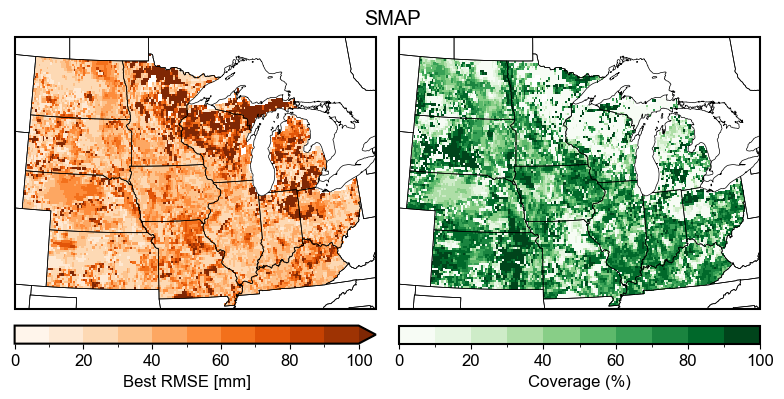

In [16]:
# SMAP
obs = 'smap'
n_cutoff = 100

fig, axs = plt.subplots(1,2, figsize=(8,5),
                        subplot_kw=dict(projection=ccrs.LambertConformal()))

plot_map(obs, n_cutoff, axs)
fig.suptitle(obs.upper(), y=0.8)
fig.tight_layout()

plt.savefig(f'../figs/calibration_{obs.upper()}_spatial.png', dpi=300)

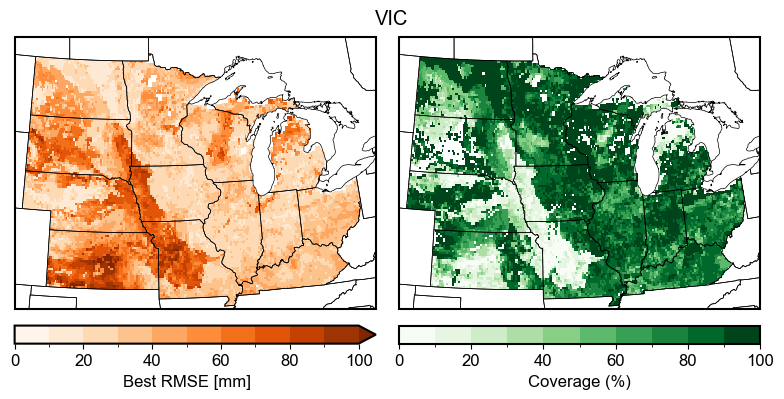

In [17]:
# VIC
obs = 'vic'
n_cutoff = 100

fig, axs = plt.subplots(1,2, figsize=(8,5),
                        subplot_kw=dict(projection=ccrs.LambertConformal()))

plot_map(obs, n_cutoff, axs)
fig.suptitle(obs.upper(), y=0.8)
fig.tight_layout()

plt.savefig(f'../figs/calibration_{obs.upper()}_spatial.png', dpi=300)

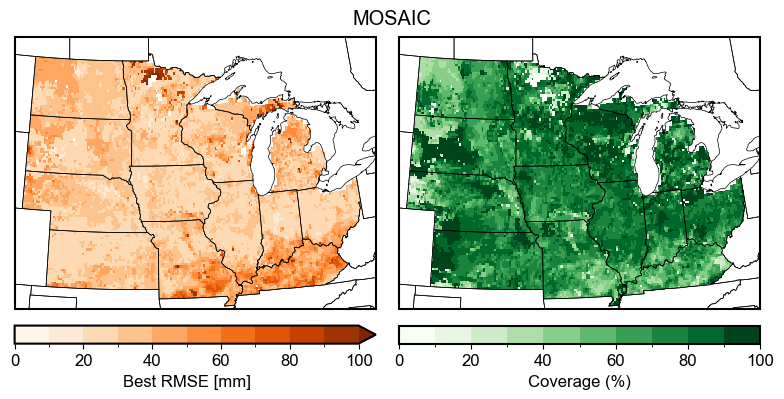

In [18]:
# MOSAIC
obs = 'mosaic'
n_cutoff = 100

fig, axs = plt.subplots(1,2, figsize=(8,5),
                        subplot_kw=dict(projection=ccrs.LambertConformal()))

plot_map(obs, n_cutoff, axs)
fig.suptitle(obs.upper(), y=0.8)
fig.tight_layout()

plt.savefig(f'../figs/calibration_{obs.upper()}_spatial.png', dpi=300)

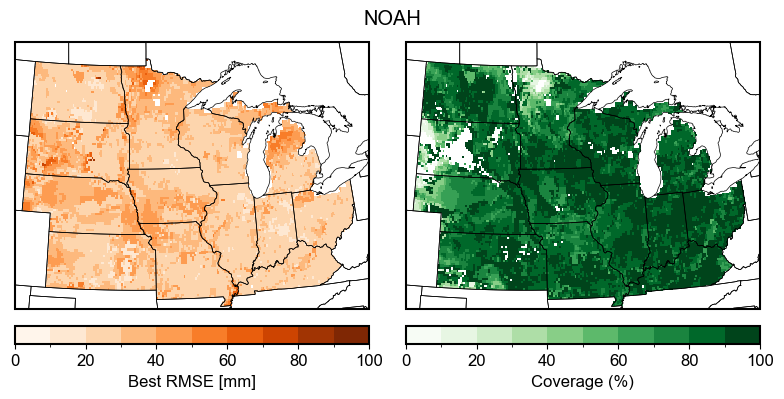

In [19]:
# NOAH
obs = 'noah'
n_cutoff = 100

fig, axs = plt.subplots(1,2, figsize=(8,5),
                        subplot_kw=dict(projection=ccrs.LambertConformal()))

plot_map(obs, n_cutoff, axs)
fig.suptitle(obs.upper(), y=0.8)
fig.tight_layout()

plt.savefig(f'../figs/calibration_{obs.upper()}_spatial.png', dpi=300)

In [36]:
def plot_ts(obs, lat, lon, n_cutoff, ylabel, xlabel, ax):
    # Read obs
    ds_obs = xr.open_dataset(f'{project_data_path}/WBM/precalibration/centralUS/{obs.upper()}_validation.nc')
    obs_tmp = ds_obs.isel(time=slice(200,3000)).sel(lat=lat, lon=lon, method='nearest')
    
    # Get top N_cutoff params
    iparam_top_n = df_res.sort_values(by=f'{obs}_rmse')['iparam'].to_numpy()[:n_cutoff]
    # Get best
    iparam_best = iparam_top_n[0]
    ds_best = read_sim(iparam_best).isel(time=slice(100,3000)).sel(lat=lat, lon=lon, method='nearest')
    ds_best = ds_best.where(ds_best.time.isin(obs_tmp.time), drop=True).soilMoist
    
    # For surprise index
    sim_all = []
    
    # Plot simulations
    for iparam in iparam_top_n:
        # Read
        ds_tmp = read_sim(iparam).isel(time=slice(200,3000)).sel(lat=lat, lon=lon, method='nearest')
        # Align datetimes
        ds_tmp = ds_tmp.where(ds_tmp.time.isin(obs_tmp.time), drop=True).soilMoist
        # Plot
        ds_tmp.plot(ax=ax, color='silver', alpha=0.8)
        # Append for surpise index
        sim_all.append(ds_tmp.to_numpy())
    
    # Plot obs
    obs_tmp = obs_tmp.where(obs_tmp.time.isin(ds_tmp.time), drop=True).soilMoist
    obs_tmp.plot(ax=ax, color='darkred', zorder=3)

    # Plot best
    ds_best.plot(ax=ax, color='dimgrey', zorder=2)
    best_rmse = np.sqrt(((ds_best - obs_tmp)**2).mean())
    
    # Get surprise index
    maxs = np.max(sim_all, axis=0)
    mins = np.min(sim_all, axis=0)
    
    coverage = 1 - ((((obs_tmp.to_numpy() > maxs).sum() + (obs_tmp.to_numpy() < mins).sum())) / len(obs_tmp))
    
    # Print info
    text_str = '\n'.join((f"Best RMSE: {best_rmse:.2f}mm", \
                         f"Coverage: {100*coverage:.2f}%"))
    
    ax.text(x=0.65, y=0.16,
            s = text_str,
            transform=ax.transAxes,
            verticalalignment='top',
            horizontalalignment='left',
            bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8),
            fontsize=10)

    ax.grid()
    ax.set_title(obs.upper())
    ax.set_ylabel(ylabel)
    ax.set_xlabel(xlabel)

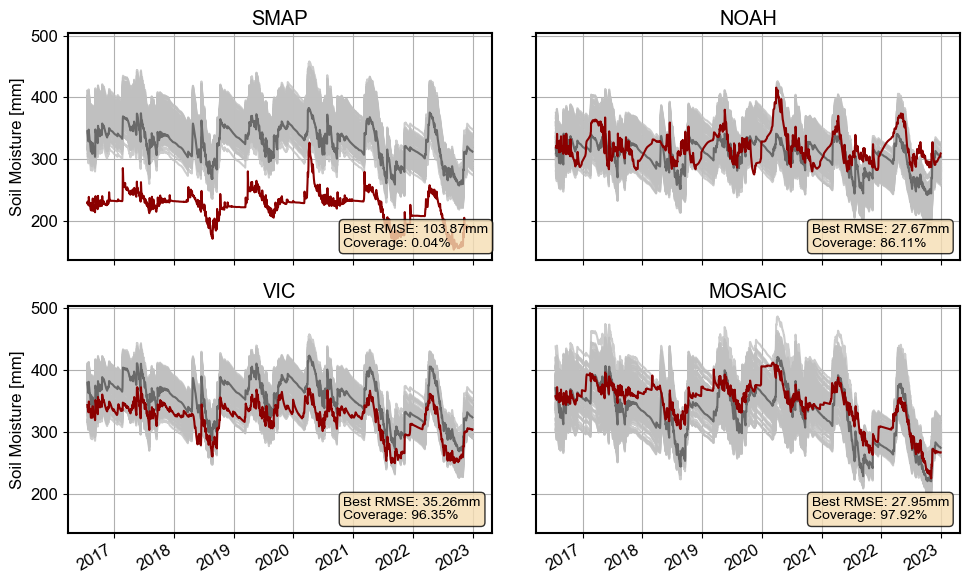

In [37]:
# Main plot
lat, lon = 46,-90.8
n_cutoff = 100

fig, axs = plt.subplots(2,2, figsize=(10,6), sharey=True, sharex=True)

plot_ts("smap", lat, lon, n_cutoff, "Soil Moisture [mm]", "", axs[0,0])
plot_ts("noah", lat, lon, n_cutoff, "", "", axs[0,1])
plot_ts("vic", lat, lon, n_cutoff, "Soil Moisture [mm]", "", axs[1,0])
plot_ts("mosaic", lat, lon, n_cutoff, "", "", axs[1,1])

plt.tight_layout()
# plt.savefig('../figs/lat40nlon90w_ts_top100.pdf')
plt.show()

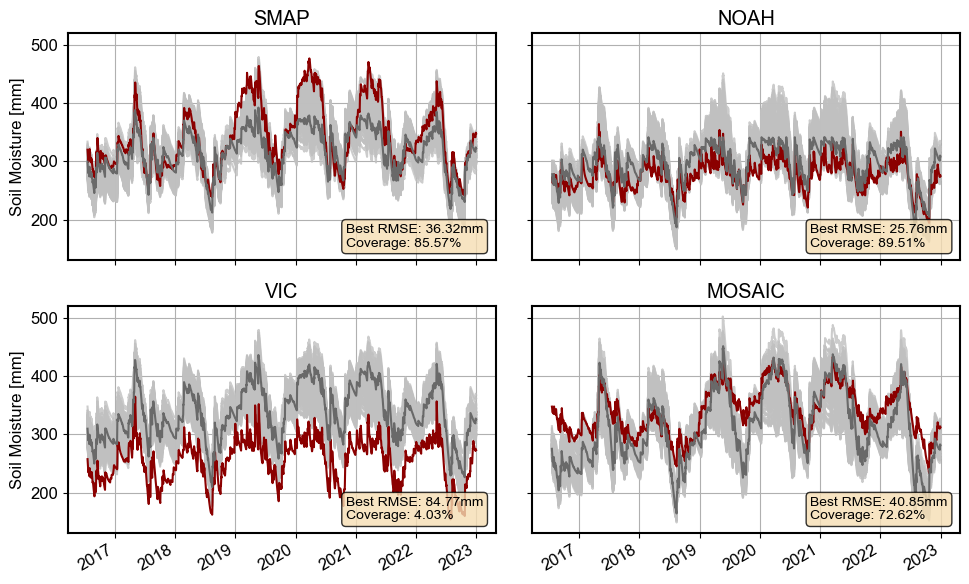

In [32]:
# Main plot
lat, lon = 37.8,-93.5
n_cutoff = 100

fig, axs = plt.subplots(2,2, figsize=(10,6), sharey=True, sharex=True)

plot_ts("smap", lat, lon, n_cutoff, "Soil Moisture [mm]", "", axs[0,0])
plot_ts("noah", lat, lon, n_cutoff, "", "", axs[0,1])
plot_ts("vic", lat, lon, n_cutoff, "Soil Moisture [mm]", "", axs[1,0])
plot_ts("mosaic", lat, lon, n_cutoff, "", "", axs[1,1])

plt.tight_layout()
# plt.savefig('../figs/lat40nlon90w_ts_top100.pdf')
plt.show()

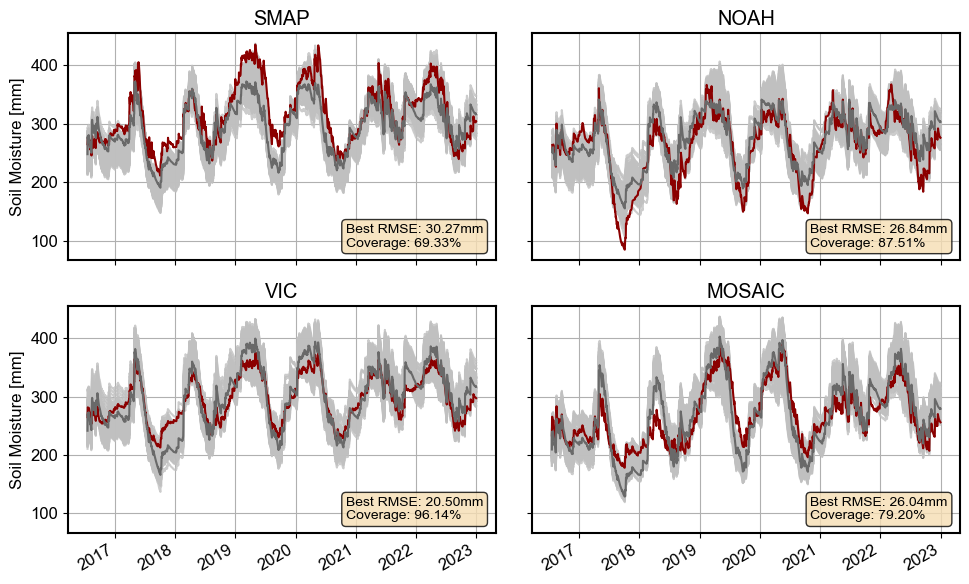

In [33]:
# Main plot
lat, lon = 40,-90
n_cutoff = 100

fig, axs = plt.subplots(2,2, figsize=(10,6), sharey=True, sharex=True)

plot_ts("smap", lat, lon, n_cutoff, "Soil Moisture [mm]", "", axs[0,0])
plot_ts("noah", lat, lon, n_cutoff, "", "", axs[0,1])
plot_ts("vic", lat, lon, n_cutoff, "Soil Moisture [mm]", "", axs[1,0])
plot_ts("mosaic", lat, lon, n_cutoff, "", "", axs[1,1])

plt.tight_layout()
# plt.savefig('../figs/lat40nlon90w_ts_top100.pdf')
plt.show()

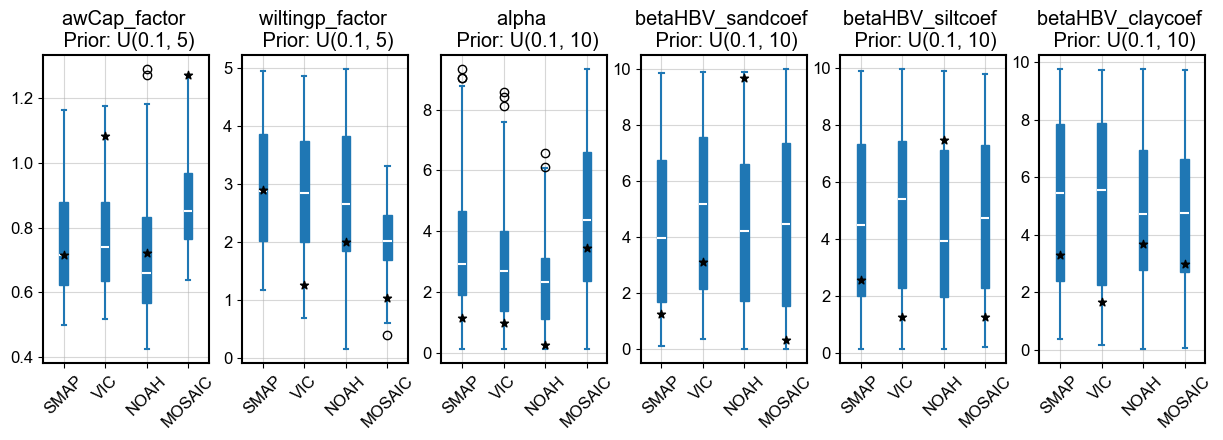

In [6]:
# Do the parameters match?
n_cutoff = 100

params = ['awCap_factor', 'wiltingp_factor', 'alpha', 'betaHBV_sandcoef', 'betaHBV_siltcoef', 'betaHBV_claycoef']
priors = ['U(0.1, 5)', 'U(0.1, 5)', 'U(0.1, 10)', 'U(0.1, 10)', 'U(0.1, 10)', 'U(0.1, 10)']
obs_all = ['smap', 'vic', 'noah', 'mosaic']
obs_colors = ['C1', 'C2', 'C3', 'C4']
obs_colors = ['C0', 'C0', 'C0', 'C0']

fig, axs = plt.subplots(1,len(params), figsize=(15,4))

for ido, obs in enumerate(obs_all):
    # Get top params
    iparam_top_n = df_res.sort_values(by=f'{obs}_rmse')['iparam'].to_numpy()[:n_cutoff]
    iparam_best = iparam_top_n[0]

    # Loop through params
    for idx, param in enumerate(params):
        # Plot
        data = df_params.iloc[iparam_top_n][param]
        bplot = axs[idx].boxplot(x=data,
                                 vert=True,
                                 positions=[ido],
                                 widths=0.2,
                                 boxprops=dict(color=obs_colors[ido]),
                                 whiskerprops=dict(color=obs_colors[ido], lw=1.5),
                                 medianprops=dict(color='white', lw=1.5),
                                 capprops=dict(color=obs_colors[ido], lw=1.5),
                                 patch_artist=True)
        for patch in bplot['boxes']:
            patch.set_facecolor(obs_colors[ido])
        # Best
        axs[idx].scatter(x = [ido],
                         y = data[iparam_best],
                         marker = '*', color='black', zorder=100)


for idx, ax in enumerate(axs):
    ax.set_title(f'{params[idx]} \n Prior: {priors[idx]}')
    ax.set_xticks(ticks=[0,1,2,3],
                  labels=[obs.upper() for obs in obs_all], rotation=45)
    ax.grid(alpha=0.5)

plt.show()

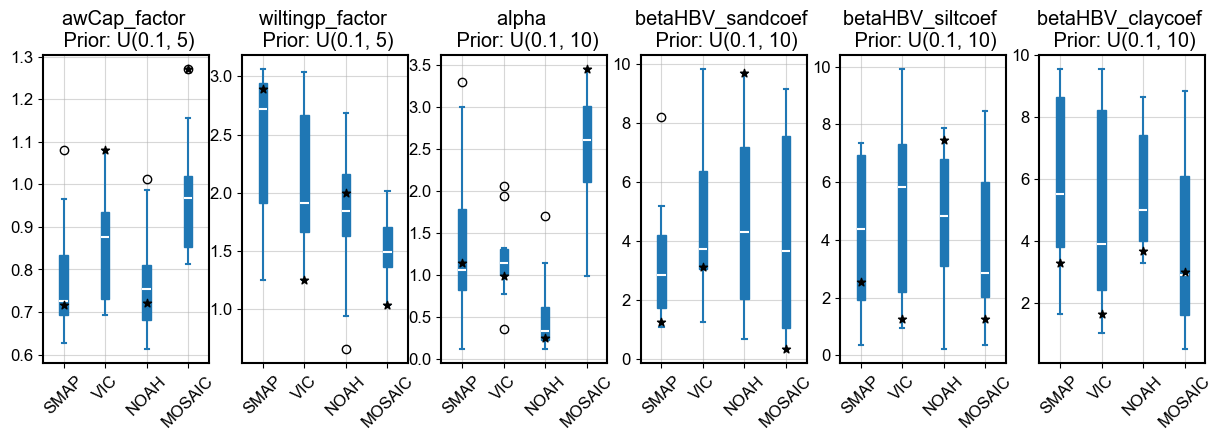

In [7]:
# Do the parameters match?
n_cutoff = 10

params = ['awCap_factor', 'wiltingp_factor', 'alpha', 'betaHBV_sandcoef', 'betaHBV_siltcoef', 'betaHBV_claycoef']
priors = ['U(0.1, 5)', 'U(0.1, 5)', 'U(0.1, 10)', 'U(0.1, 10)', 'U(0.1, 10)', 'U(0.1, 10)']
obs_all = ['smap', 'vic', 'noah', 'mosaic']
obs_colors = ['C1', 'C2', 'C3', 'C4']
obs_colors = ['C0', 'C0', 'C0', 'C0']

fig, axs = plt.subplots(1,len(params), figsize=(15,4))

for ido, obs in enumerate(obs_all):
    # Get top params
    iparam_top_n = df_res.sort_values(by=f'{obs}_rmse')['iparam'].to_numpy()[:n_cutoff]
    iparam_best = iparam_top_n[0]

    # Loop through params
    for idx, param in enumerate(params):
        # Plot
        data = df_params.iloc[iparam_top_n][param]
        bplot = axs[idx].boxplot(x=data,
                                 vert=True,
                                 positions=[ido],
                                 widths=0.2,
                                 boxprops=dict(color=obs_colors[ido]),
                                 whiskerprops=dict(color=obs_colors[ido], lw=1.5),
                                 medianprops=dict(color='white', lw=1.5),
                                 capprops=dict(color=obs_colors[ido], lw=1.5),
                                 patch_artist=True)
        for patch in bplot['boxes']:
            patch.set_facecolor(obs_colors[ido])
        # Best
        axs[idx].scatter(x = [ido],
                         y = data[iparam_best],
                         marker = '*', color='black', zorder=100)


for idx, ax in enumerate(axs):
    ax.set_title(f'{params[idx]} \n Prior: {priors[idx]}')
    ax.set_xticks(ticks=[0,1,2,3],
                  labels=[obs.upper() for obs in obs_all], rotation=45)
    ax.grid(alpha=0.5)

plt.show()

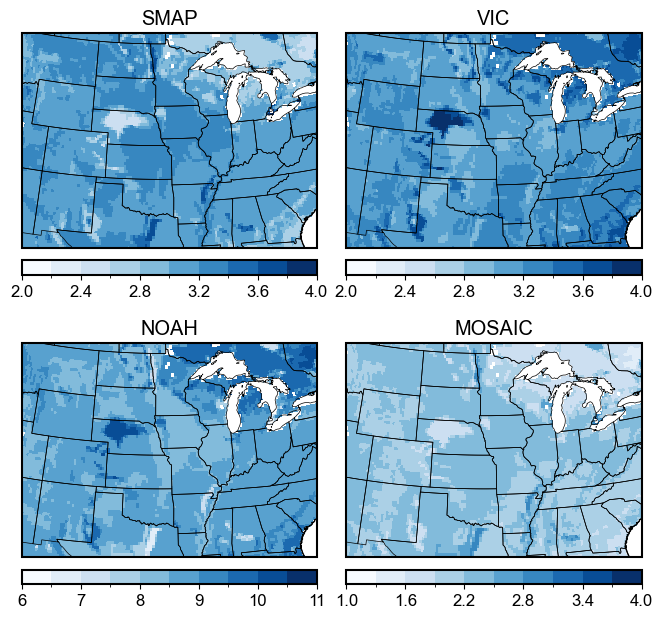

In [82]:
# Plot betaHBV
ds_soilfrac = xr.open_dataset(f'{project_data_path}/WBM/geo_inputs/soilfrac_NLDASgrid.nc')

fig, axs = plt.subplots(2,2, figsize=(8,8),
                        subplot_kw=dict(projection=ccrs.LambertConformal()),
                        gridspec_kw=dict(wspace=0.1, hspace=0.01))
axs = axs.flatten()

for ido, obs in enumerate(obs_all):
    # Get best param set
    iparam_best = df_res.sort_values(by=f'{obs}_rmse')['iparam'].iloc[0]
    # Calculate best betaHBV map
    betaHBV_sandcoef = df_params.iloc[iparam_best]['betaHBV_sandcoef']
    betaHBV_siltcoef = df_params.iloc[iparam_best]['betaHBV_siltcoef']
    betaHBV_claycoef = df_params.iloc[iparam_best]['betaHBV_claycoef']

    betaHBV = 1. + (betaHBV_sandcoef * ds_soilfrac['GLDAS_soilfraction_sand']) + \
    (betaHBV_siltcoef * ds_soilfrac['GLDAS_soilfraction_silt']) + \
    (betaHBV_claycoef * ds_soilfrac['GLDAS_soilfraction_clay'])
    # Plot
    p = betaHBV.plot(ax=axs[ido], vmin=np.round(betaHBV.min()-0.5), vmax=np.round(betaHBV.max()+0.5), cmap="Blues", add_colorbar=False, levels=11, transform=ccrs.PlateCarree())
    # Tidy
    axs[ido].set_title(obs.upper())
    # cbar
    fig.colorbar(p,
                 orientation="horizontal",
                 label=None,
                 ax=axs[ido],
                 pad=0.04)

# Tidy
xlims = [-110, -80] # central US
ylims = [30,49] # central US
for ax in axs:
    ax.coastlines()
    ax.add_feature(cfeature.STATES, edgecolor='black', linewidth=0.5)
    ax.set_extent([xlims[0], xlims[1], ylims[0], ylims[1]], ccrs.Geodetic())
plt.show()

## Soil moisture 'obs' plots

In [16]:
# Error calculation function
def calculate_error_metrics(ds1, ds2, weekly_anom):
    # Weekly anomalies if needed
    def get_weekly_anomaly(ds):
        ds_tmp = ds.copy()
        ds_tmp = ds_tmp.assign_coords(week=ds_tmp.time.dt.strftime("%W"))
        return (ds_tmp.groupby('week') - ds_tmp.groupby("week").mean("time"))
    
    # Calculate weekly anom if desired
    if weekly_anom:
        ds1_tmp = get_weekly_anomaly(ds1)
        ds2_tmp = get_weekly_anomaly(ds2)
    else:
        ds1_tmp = ds1.copy()
        ds2_tmp = ds2.copy()
    
    # Linear correlation
    out_corr = xr.corr(ds1_tmp, ds2_tmp, dim='time')
    
    # MSE
    out_mse = np.sqrt(((ds1_tmp - ds2_tmp)**2)).mean(dim='time')

    # Merge and return
    out = xr.merge([xr.Dataset({'perason_r':out_corr}),
                    xr.Dataset({'rmse':out_mse})])

    return out

In [7]:
# Read all
ds_vic = xr.open_mfdataset(f'{nldas_path}/VIC/daily/*A20*.nc')['SOILM0_100cm'].isel(depth=0)
ds_noah = xr.open_mfdataset(f'{nldas_path}/NOAH/daily/*A20*.nc')['SOILM'].isel(depth=1)
ds_mosaic = xr.open_mfdataset(f'{nldas_path}/MOSAIC/daily/*A20*.nc')['SOILM'].isel(depth=1)

ds_smap = xr.open_mfdataset(f'{smap_path}/processed_nldas_grid/SMAP_L4_SM_gph_all_nldas_*.nc')['sm_rootzone']

In [8]:
%%time 

# Calculate all error metrics
weekly_anom = True

vic_noah_error = calculate_error_metrics(ds_vic, ds_noah, weekly_anom).compute()
vic_mosaic_error = calculate_error_metrics(ds_vic, ds_mosaic, weekly_anom).compute()
vic_smap_error = calculate_error_metrics(ds_vic, ds_smap, weekly_anom).compute()

noah_mosaic_error = calculate_error_metrics(ds_noah, ds_mosaic, weekly_anom).compute()
noah_smap_error = calculate_error_metrics(ds_noah, ds_smap, weekly_anom).compute()

mosaic_smap_error = calculate_error_metrics(ds_mosaic, ds_smap, weekly_anom).compute()

CPU times: user 6min, sys: 8.16 s, total: 6min 8s
Wall time: 6min 19s


In [ ]:
# Store all
vic_noah_error.to_netcdf(f'{project_data_path}/WBM/soil_obs_errors/vic_noah_errors.nc')
vic_mosaic_error.to_netcdf(f'{project_data_path}/WBM/soil_obs_errors/vic_mosaic_errors.nc')
vic_smap_error.to_netcdf(f'{project_data_path}/WBM/soil_obs_errors/vic_smap_errors.nc')

noah_mosaic_error.to_netcdf(f'{project_data_path}/WBM/soil_obs_errors/noah_mosaic_errors.nc')
noah_smap_error.to_netcdf(f'{project_data_path}/WBM/soil_obs_errors/noah_smap_errors.nc')

mosaic_smap_error.to_netcdf(f'{project_data_path}/WBM/soil_obs_errors/mosaic_smap_errors.nc')

In [ ]:
# fig, axs = plt.subplots(1,2, figsize=(12,8),
#                         subplot_kw={'projection':ccrs.LambertConformal()},
#                        gridspec_kw={'wspace':0.05})

# p_corr = vic_noah_error.corr.plot(ax=axs[0], transform=ccrs.PlateCarree(),
#                                   add_colorbar=False,
#                                   levels=11
#                                  )
# p_mse = vic_noah_error.mse.plot(ax=axs[1], transform=ccrs.PlateCarree(),
#                                 add_colorbar=False,
#                                 levels=11
#                                )

# axs[0].add_feature(cfeature.STATES, edgecolor='white', linewidth=1)
# axs[1].add_feature(cfeature.STATES, edgecolor='white', linewidth=1)

# fig.colorbar(p_corr, ax = axs[0],
#              orientation="horizontal",
#              label="Linear correlation",
#              pad=0.04)

# fig.colorbar(p_mse, ax = axs[1],
#              orientation="horizontal",
#              label="Mean Square Error",
#              pad=0.04)

# fig.suptitle("Noah VIC soil moisture anomaly comparison (2016-2022)", y=0.63)

# plt.show()

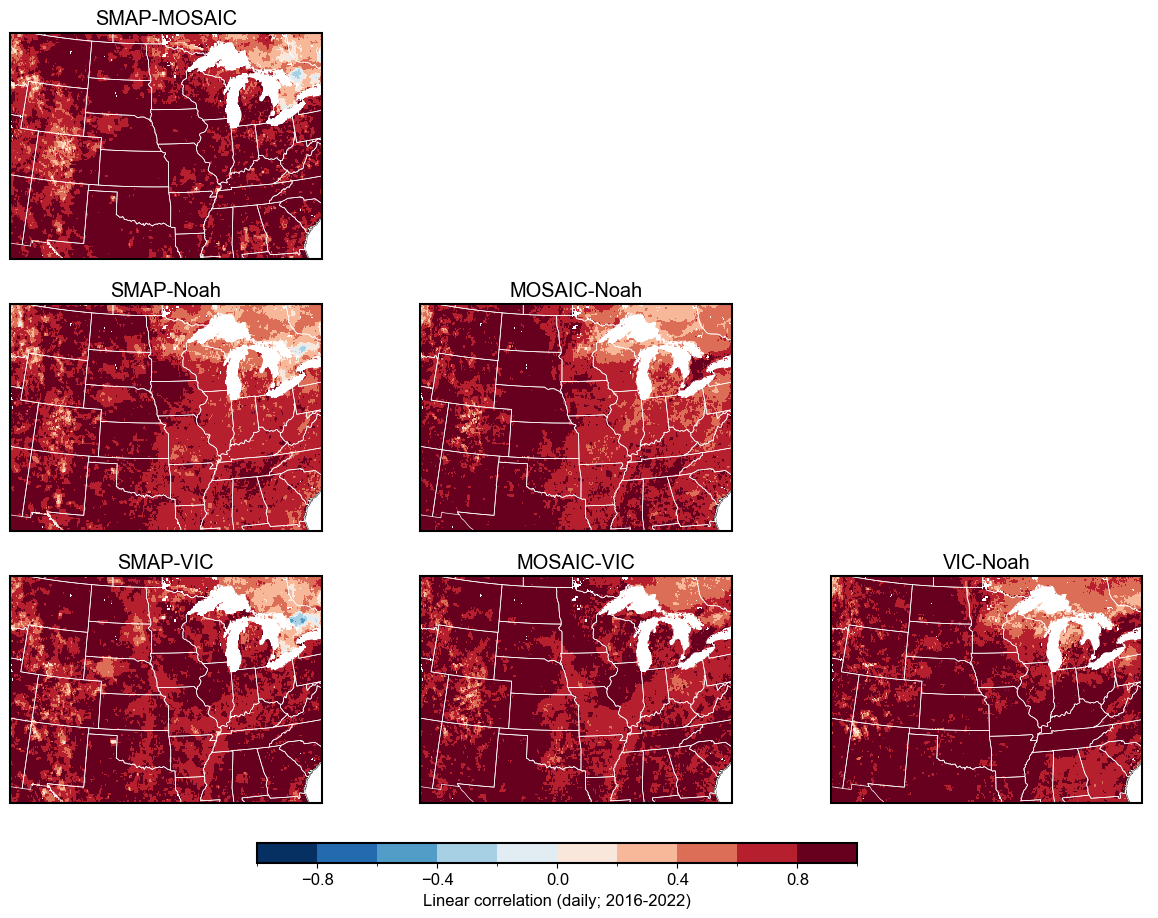

In [12]:
# Correlation plot
fig, axs = plt.subplots(3,3, figsize=(15,10), subplot_kw=dict(projection=ccrs.LambertConformal()))

xlims = [-110, -80] # central US
ylims = [30,49] # central US

mosaic_smap_error.corr.plot(ax=axs[0,0], vmin=-1, vmax=1, cmap="RdBu_r", add_colorbar=False, levels=11, transform=ccrs.PlateCarree())
axs[0,0].set_title("SMAP-MOSAIC")

noah_smap_error.corr.plot(ax=axs[1,0], vmin=-1, vmax=1, cmap="RdBu_r", add_colorbar=False, levels=11, transform=ccrs.PlateCarree())
axs[1,0].set_title("SMAP-Noah")

vic_smap_error.corr.plot(ax=axs[2,0], vmin=-1, vmax=1, cmap="RdBu_r", add_colorbar=False, levels=11, transform=ccrs.PlateCarree())
axs[2,0].set_title("SMAP-VIC")

noah_mosaic_error.corr.plot(ax=axs[1,1], vmin=-1, vmax=1, cmap="RdBu_r", add_colorbar=False, levels=11, transform=ccrs.PlateCarree())
axs[1,1].set_title("MOSAIC-Noah")

vic_mosaic_error.corr.plot(ax=axs[2,1], vmin=-1, vmax=1, cmap="RdBu_r", add_colorbar=False, levels=11, transform=ccrs.PlateCarree())
axs[2,1].set_title("MOSAIC-VIC")

p=vic_noah_error.corr.plot(ax=axs[2,2], vmin=-1, vmax=1, cmap="RdBu_r", add_colorbar=False, levels=11, transform=ccrs.PlateCarree())
axs[2,2].set_title("VIC-Noah")

for ax in [axs[0,0],axs[1,0],axs[2,0],axs[1,1],axs[2,1],axs[2,2]]:
    ax.coastlines()
    ax.add_feature(cfeature.STATES, edgecolor='white', linewidth=0.5)
    ax.set_extent([xlims[0], xlims[1], ylims[0], ylims[1]], ccrs.Geodetic())
    
axs[0,1].axis('off')
axs[0,2].axis('off')
axs[1,2].axis('off')

cbar_ax = fig.add_axes([0.3, 0.05, 0.4, 0.02])
cbar = fig.colorbar(p,
                    cax=cbar_ax,
                    orientation="horizontal",
                    label="Linear correlation (daily; 2016-2022)")

# plt.savefig('./figs/pearson_GMFD-PRISM-gridMET_1981-2014_Hamon_midwest.png', dpi=600)
plt.show()

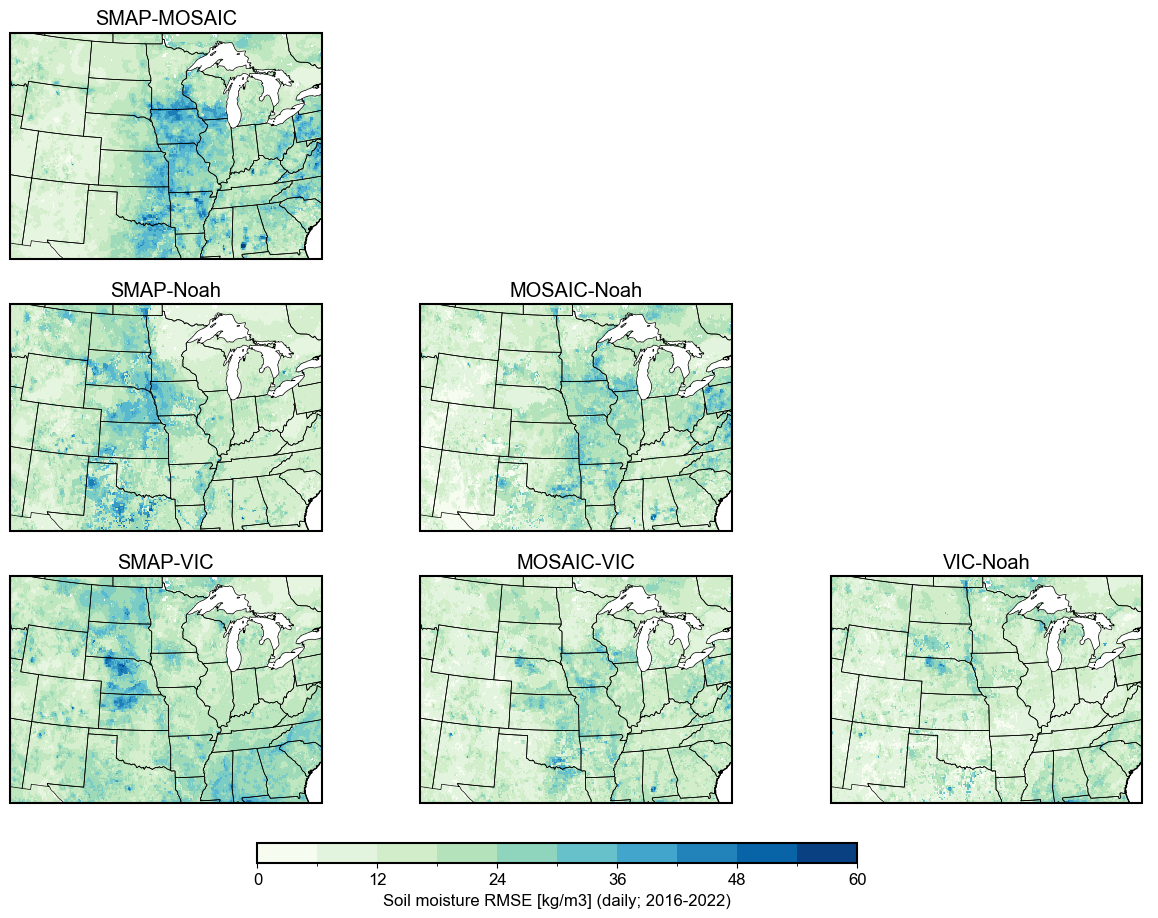

In [15]:
# RMSE plot
fig, axs = plt.subplots(3,3, figsize=(15,10), subplot_kw=dict(projection=ccrs.LambertConformal()))

xlims = [-110, -80] # central US
ylims = [30,49] # central US

mosaic_smap_error.mse.plot(ax=axs[0,0], vmin=0, vmax=60, cmap="GnBu", add_colorbar=False, levels=11, transform=ccrs.PlateCarree())
axs[0,0].set_title("SMAP-MOSAIC")

noah_smap_error.mse.plot(ax=axs[1,0], vmin=0, vmax=60, cmap="GnBu", add_colorbar=False, levels=11, transform=ccrs.PlateCarree())
axs[1,0].set_title("SMAP-Noah")

vic_smap_error.mse.plot(ax=axs[2,0], vmin=0, vmax=60, cmap="GnBu", add_colorbar=False, levels=11, transform=ccrs.PlateCarree())
axs[2,0].set_title("SMAP-VIC")

noah_mosaic_error.mse.plot(ax=axs[1,1], vmin=0, vmax=60, cmap="GnBu", add_colorbar=False, levels=11, transform=ccrs.PlateCarree())
axs[1,1].set_title("MOSAIC-Noah")

vic_mosaic_error.mse.plot(ax=axs[2,1], vmin=0, vmax=60, cmap="GnBu", add_colorbar=False, levels=11, transform=ccrs.PlateCarree())
axs[2,1].set_title("MOSAIC-VIC")

p=vic_noah_error.mse.plot(ax=axs[2,2], vmin=0, vmax=60, cmap="GnBu", add_colorbar=False, levels=11, transform=ccrs.PlateCarree())
axs[2,2].set_title("VIC-Noah")

for ax in [axs[0,0],axs[1,0],axs[2,0],axs[1,1],axs[2,1],axs[2,2]]:
    ax.coastlines()
    ax.add_feature(cfeature.STATES, edgecolor='black', linewidth=0.5)
    ax.set_extent([xlims[0], xlims[1], ylims[0], ylims[1]], ccrs.Geodetic())
    
axs[0,1].axis('off')
axs[0,2].axis('off')
axs[1,2].axis('off')

cbar_ax = fig.add_axes([0.3, 0.05, 0.4, 0.02])
cbar = fig.colorbar(p,
                    cax=cbar_ax,
                    orientation="horizontal",
                    label="Soil moisture RMSE [kg/m3] (daily; 2016-2022)")

# plt.savefig('./figs/pearson_GMFD-PRISM-gridMET_1981-2014_Hamon_midwest.png', dpi=600)
plt.show()